In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
rt_iot2022 = fetch_ucirepo(id=942)

# Data
X = rt_iot2022.data.features
y = rt_iot2022.data.targets

# Print metadata and variable information
#print(rt_iot2022.metadata)
#print(rt_iot2022.variables)

In [4]:
print(y.head())  # See the first few entries to understand its structure
print(type(y))   # This should be <class 'pandas.core.series.Series'>

    Attack_type
0  MQTT_Publish
1  MQTT_Publish
2  MQTT_Publish
3  MQTT_Publish
4  MQTT_Publish
<class 'pandas.core.frame.DataFrame'>


In [5]:
df = pd.concat([X, y], axis=1)  # Make sure y is a Series or adjust accordingly

# Check the first few rows of the dataframe
print(df.head())

# Encoder for the 'Attack_type' column
encoder = LabelEncoder()
df['Attack_type'] = encoder.fit_transform(df['Attack_type'])

# List of feature columns: assuming 'Attack_type' is now the last column
feature_columns = df.columns[:-1]  # All columns except the last one

   id.orig_p  id.resp_p proto service  flow_duration  fwd_pkts_tot  \
0      38667       1883   tcp    mqtt      32.011598             9   
1      51143       1883   tcp    mqtt      31.883584             9   
2      44761       1883   tcp    mqtt      32.124053             9   
3      60893       1883   tcp    mqtt      31.961063             9   
4      51087       1883   tcp    mqtt      31.902362             9   

   bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  ...  \
0             5                  3                  3          0.281148  ...   
1             5                  3                  3          0.282277  ...   
2             5                  3                  3          0.280164  ...   
3             5                  3                  3          0.281593  ...   
4             5                  3                  3          0.282111  ...   

   active.std     idle.min     idle.max     idle.tot     idle.avg  idle.std  \
0         0.0  2972

In [6]:
# Assuming df is your DataFrame containing both features and the target column
# Identify categorical columns - this might need to be adjusted based on actual data inspection
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'Attack_type']
df = pd.get_dummies(df, columns=categorical_cols)

# Encode labels
encoder = LabelEncoder()
df['Attack_type'] = encoder.fit_transform(df['Attack_type'])

# Split into features and labels
X = df.drop('Attack_type', axis=1).values
y = df['Attack_type'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Convert to tensors
X_tensor = torch.tensor(X_scaled.astype(np.float32))
y_tensor = torch.tensor(y.astype(np.int64))

# Create TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split dataset
num_total = len(dataset)
num_train = int(num_total * 0.7)
num_valid = int(num_total * 0.15)
num_test = num_total - num_train - num_valid

train_dataset, valid_dataset, test_dataset = random_split(dataset, [num_train, num_valid, num_test])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class IOTClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(IOTClassifier, self).__init__()
        self.network = nn.Sequential(
            # First hidden layer
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            # Second hidden layer
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),

            # Third hidden layer
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),

            # Fourth hidden layer
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),

            # Output layer
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

In [9]:
# Determine number of features and classes
num_features = X_tensor.shape[1]
num_classes = len(encoder.classes_)

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = IOTClassifier(num_features, num_classes).to(device)

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=10):
    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = val_loss / len(valid_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses

# Example usage
num_epochs = 20
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=num_epochs)

Epoch 1, Train Loss: 0.1094, Validation Loss: 0.0487
Epoch 2, Train Loss: 0.0328, Validation Loss: 0.0265
Epoch 3, Train Loss: 0.0256, Validation Loss: 0.0401
Epoch 4, Train Loss: 0.0219, Validation Loss: 0.0232
Epoch 5, Train Loss: 0.0187, Validation Loss: 0.0370
Epoch 6, Train Loss: 0.0176, Validation Loss: 0.0274
Epoch 7, Train Loss: 0.0190, Validation Loss: 0.0352
Epoch 8, Train Loss: 0.0161, Validation Loss: 0.0531
Epoch 9, Train Loss: 0.0141, Validation Loss: 0.0547
Epoch 10, Train Loss: 0.0141, Validation Loss: 0.0680
Epoch 11, Train Loss: 0.0134, Validation Loss: 0.0959
Epoch 12, Train Loss: 0.0150, Validation Loss: 0.1886
Epoch 13, Train Loss: 0.0132, Validation Loss: 0.1446
Epoch 14, Train Loss: 0.0127, Validation Loss: 0.0516
Epoch 15, Train Loss: 0.0134, Validation Loss: 0.0426
Epoch 16, Train Loss: 0.0129, Validation Loss: 0.1105
Epoch 17, Train Loss: 0.0143, Validation Loss: 0.0780
Epoch 18, Train Loss: 0.0126, Validation Loss: 0.0332
Epoch 19, Train Loss: 0.0180, Validat

In [12]:
model_path = './pytorch_IOT_model.pth'  # Define the path where you want to save the model
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./pytorch_IOT_model.pth


In [13]:
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    
    y_true = []
    y_pred = []
    test_loss = 0.0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    test_loss /= total
    overall_accuracy = accuracy_score(y_true, y_pred)
    return test_loss, overall_accuracy, y_true, y_pred

# Assuming your model, criterion, and test_loader have been defined and are ready to use
test_loss, overall_accuracy, y_true, y_pred = test_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {overall_accuracy:.4f}")

Test Loss: 0.0117
Test Accuracy: 0.9970


In [14]:
def class_accuracy(y_true, y_pred, labels):
    # Generate a confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    return class_accuracy

# Assuming labels are encoded from 0 to n_classes-1
n_classes = len(set(y_true))  # Or however many classes you have
class_labels = list(range(n_classes))  # Adjust if your labels are differently formatted

accuracies = class_accuracy(y_true, y_pred, class_labels)
for idx, acc in enumerate(accuracies):
    print(f"Accuracy of Class {idx} ({class_labels[idx]}): {acc:.4f}")

Accuracy of Class 0 (0): 0.9873
Accuracy of Class 1 (1): 0.8602
Accuracy of Class 2 (2): 1.0000
Accuracy of Class 3 (3): 0.9985
Accuracy of Class 4 (4): 0.7143
Accuracy of Class 5 (5): 0.5000
Accuracy of Class 6 (6): 1.0000
Accuracy of Class 7 (7): 1.0000
Accuracy of Class 8 (8): 0.9948
Accuracy of Class 9 (9): 1.0000
Accuracy of Class 10 (10): 0.9861
Accuracy of Class 11 (11): 0.9362


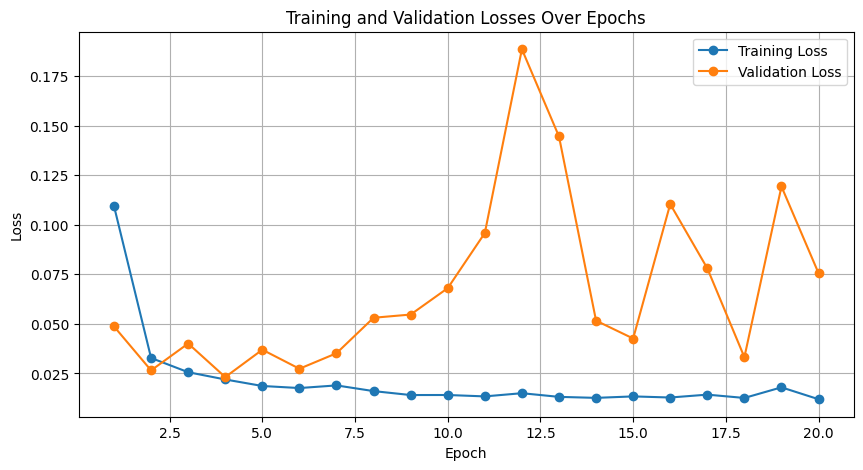

In [15]:
# Assuming train_losses and val_losses are lists containing the loss values per epoch
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('PyTorch_IOT_train_val_loss.svg', format='svg')  # Save as SVG
plt.show()

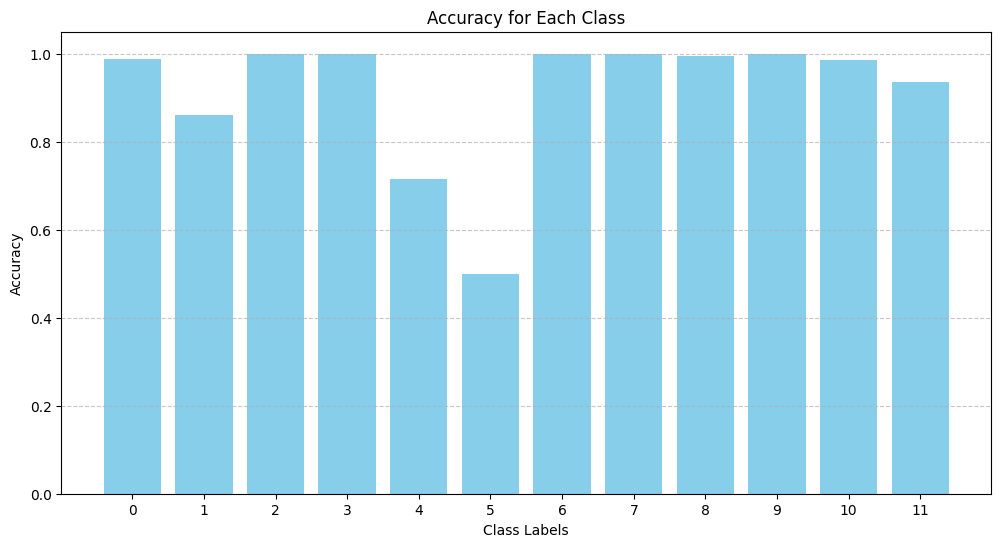

In [16]:
class_labels = list(range(len(accuracies)))  # Update this if you have specific class names or labels

plt.figure(figsize=(12, 6))
plt.bar(class_labels, accuracies, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.xticks(ticks=class_labels, labels=class_labels)  # Set class labels as x-tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('PyTorch_IOT_class_accuracies.svg', format='svg')  # Save as SVG
plt.show()